In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from transformers import AutoTokenizer, AutoModel
import seaborn as sns
from multiprocessing import Pool
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import multiprocessing
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from tqdm.auto import tqdm
import config

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [3]:
path = Path('/data/yelp/')
assert path.exists()

In [4]:
!ls {path}

Dataset_User_Agreement.pdf	     yelp_academic_dataset_review.json
balanced_simplified_reviews.pkl      yelp_academic_dataset_tip.json
model_save			     yelp_academic_dataset_user.json
yelp_academic_dataset_business.json  yelp_reviews_simple_2000000.json
yelp_academic_dataset_checkin.json


In [5]:
balanced_simplified_reviews = pd.read_pickle(path/'balanced_simplified_reviews.pkl')

In [6]:
balanced_simplified_reviews['stars'] = balanced_simplified_reviews['stars'] - 1
balanced_simplified_reviews

,text,stars
31,This actually used to be one of my favorite ho...,1
62,Decent food. Fishermen lobster or even congee ...,1
77,"Pros: Fun atmosphere, great for people watchin...",1
85,"I love bookstores, and I love to spend some ti...",1
86,"I passed Five Guys, In-N-Out, Carl's Jr, and S...",1
...,...,...
1999994,This place is excellent. I never knew about th...,4
1999995,An all-time favorite for me and my wife. We g...,4
1999996,I have been coming here for over a year now fo...,4
1999997,Worst customer service on the planet! Came in ...,0


### Prepare tokenizer and data loaders

In [7]:
NUM_CLASSES = len(balanced_simplified_reviews['stars'].unique())

In [8]:
tokenizer = AutoTokenizer.from_pretrained(config.PRE_TRAINED_MODEL_NAME)

In [9]:
def parallelize_dataframe(df, func, n_cores=8):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [10]:
def count_tokens(df):
    df['text_len'] = df['text'].apply(lambda t : len(tokenizer.encode(t, max_length=config.MAX_LENGTH)))
    return df

In [11]:
%%time

balanced_simplified_reviews = parallelize_dataframe(balanced_simplified_reviews, count_tokens, 10)

CPU times: user 1.87 s, sys: 3.46 s, total: 5.33 s
Wall time: 4min 58s


Checking the distribution of the length of tokens

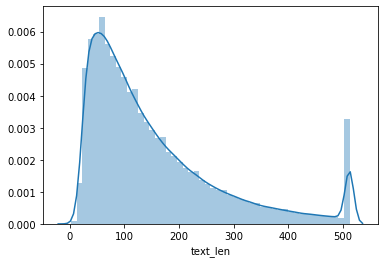

In [12]:
sns.distplot(balanced_simplified_reviews['text_len'])

In [13]:
class YelpDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews, self.targets,  self.tokenizer, self.max_len = reviews.to_numpy(), targets.to_numpy(), tokenizer, max_len
        
    def __len__(self):
        return len(self.reviews)
        
    def __getitem__(self, item):
        review = self.reviews[item]
        tokens = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'review': review,
            'input_ids': tokens['input_ids'].flatten(),
            'attention_mask': tokens['attention_mask'].flatten(),
            'target': torch.tensor(self.targets[item]).long()
        }

In [14]:
RANDOM_SEED = 42

def seed_everything(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)

In [15]:
train_df, test_df = train_test_split(balanced_simplified_reviews, test_size=0.1, random_state=RANDOM_SEED, 
                                     stratify=balanced_simplified_reviews.stars.values)
valid_df, test_df = train_test_split(test_df, test_size=0.5, random_state=RANDOM_SEED, stratify=test_df.stars.values)
train_df.shape, test_df.shape, valid_df.shape

((713507, 3), (39640, 3), (39639, 3))

Checking if the distribution is even. We used `stratify` so it should be.

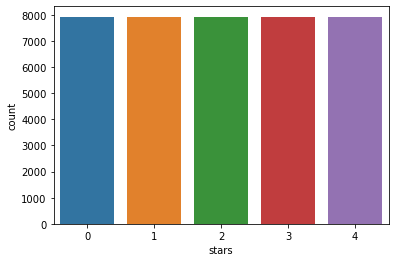

In [16]:
sns.countplot(valid_df['stars'])

In [17]:
def create_data_loader(df, tokenizer, max_length, batch_size):
    ds = YelpDataset(df['text'], df['stars'], tokenizer, max_length)
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=multiprocessing.cpu_count() - 1
    )

In [18]:
BATCH_SIZE=16

train_dl = create_data_loader(train_df, tokenizer, config.MAX_LENGTH, BATCH_SIZE)
test_dl = create_data_loader(test_df, tokenizer, config.MAX_LENGTH, BATCH_SIZE)
valid_dl = create_data_loader(valid_df, tokenizer, config.MAX_LENGTH, BATCH_SIZE)

In [19]:
sample_record = next(iter(train_dl))
sample_record['input_ids'][0]

tensor([  101,   146,  1355,  1107,  1111,   170, 15854,  1105,  1662,  1226,
          132,  6976,  1250,   106,  2038,  1555,  1105,  2209,  1106,  6505,
          119,  1130,  1901,   117,  1108,  1304,  2816,  1106,  1525,  1152,
         1127,  1764,  4931,  1105,  2356,   170, 23290,   119,   146,  4664,
        18029,   119,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

In [20]:
sample_record['attention_mask'][0]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## Prepare training

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"

In [22]:
model = BertForSequenceClassification.from_pretrained(config.PRE_TRAINED_MODEL_NAME, num_labels = NUM_CLASSES, 
                                                      output_attentions = False, output_hidden_states = False)
model = model.to(device)

In [23]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 1e-3},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [24]:
len([p for n, p in param_optimizer if not any(nd in n for nd in no_decay)]), len([p for n, p in param_optimizer if any(nd in n for nd in no_decay)])

(77, 124)

In [25]:
# AdamW Adam algorithm with weight decay fix
optimizer = AdamW(optimizer_parameters, 
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                 )

In [26]:
EPOCHS = 3

total_steps = len(train_dl) * EPOCHS

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [27]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [28]:
import os
import shutil
import pickle

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

def save_model(model, tokenizer, output_dir = path/'model_save'):

    # Create output directory if needed
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    else:
        shutil.rmtree(output_dir)
        os.makedirs(output_dir)

    print(f"Saving model to {output_dir}")

    tokenizer.save_pretrained(output_dir)
    torch.save(model, output_dir/'model')

### Training Loop

In [29]:
def grab_batch_data(batch):
    input_ids = batch['input_ids'].to(device)
    input_mask = batch['attention_mask'].to(device)
    labels = batch['target'].to(device)
    return input_ids, input_mask, labels

def eval_fn():
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    
    # Evaluate data for one epoch
    for batch in tqdm(valid_dl, total=len(valid_dl)):
        input_ids, input_mask, labels = grab_batch_data(batch)
        with torch.no_grad():        
            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            (loss, logits) = model(input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=input_mask,
                                   labels=labels)
            # Accumulate the validation loss.
            total_eval_loss += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = labels.to('cpu').numpy()

            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            total_eval_accuracy += flat_accuracy(logits, label_ids)
            
    avg_val_accuracy = total_eval_accuracy / len(valid_dl)
    avg_val_loss = total_eval_loss / len(valid_dl)
    print(f"  Accuracy: {avg_val_accuracy:.2f}")
    print(f"  Validation Loss: {avg_val_loss:.2f}")
    return {
        'Accuracy': avg_val_accuracy,
        'Validation Loss': avg_val_loss
    }

In [30]:
training_stats = []
best_accuracy = 0
for epoch in tqdm(range(0, EPOCHS), total=EPOCHS):
    total_train_loss = 0
    model.train()
    for step, batch in tqdm(enumerate(train_dl), total=len(train_dl)):
        input_ids, input_mask, labels = grab_batch_data(batch)
        model.zero_grad()  
        loss, logits = model(input_ids, 
                             token_type_ids=None, 
                             attention_mask=input_mask, 
                             labels=labels)
        total_train_loss += loss.item()
        if step % 2000 == 0:
            print(f'{step}: Loss: {total_train_loss / (step + 1)}\r')
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    
    avg_train_loss = total_train_loss / len(train_dl)
    print("")
    print(f"  Average training loss: {avg_train_loss}")
    stats_info = eval_fn()
    stats_info['epoch'], stats_info['Average training loss'] = epoch, avg_train_loss
    training_stats.append(stats_info)
    save_model(model, tokenizer, output_dir=path/f'output_dir_{epoch}')
    if stats_info['Accuracy'] > best_accuracy:
        save_model(model, tokenizer, output_dir=path/f'output_dir_best')
        best_accuracy = stats_info['Accuracy']

0: Loss: 1.6956056356430054
2000: Loss: 0.913485184974637
4000: Loss: 0.8684260028134403
6000: Loss: 0.8398852016236102
8000: Loss: 0.8233545313547022
10000: Loss: 0.8108714757582722
12000: Loss: 0.8007321274846249
14000: Loss: 0.79342095732889
16000: Loss: 0.7866708177813112
18000: Loss: 0.7804215775922658
20000: Loss: 0.7749717066125104
22000: Loss: 0.7705255042393963
24000: Loss: 0.7662243673671887
26000: Loss: 0.7626570274378629
28000: Loss: 0.7590905356175567
30000: Loss: 0.7558343703409206
32000: Loss: 0.7525521660391411
34000: Loss: 0.7501129059050946
36000: Loss: 0.7475381722853669
38000: Loss: 0.744884864931006
40000: Loss: 0.7424146648571731
42000: Loss: 0.7403439416030723
44000: Loss: 0.7379456776092276


  Average training loss: 0.7372984683460847



  Accuracy: 0.69
  Validation Loss: 0.70
Saving model to /data/yelp/output_dir_0
Saving model to /data/yelp/output_dir_best


0: Loss: 0.554550290107727
2000: Loss: 0.6706715266386429
4000: Loss: 0.6691154521410241
6000: Loss: 0.6633898348380994
8000: Loss: 0.6618968007743634
10000: Loss: 0.6592504244922411
12000: Loss: 0.6563260139932077
14000: Loss: 0.6549207708729768
16000: Loss: 0.6526472424212548
18000: Loss: 0.6497491117262402
20000: Loss: 0.6472170887979934
22000: Loss: 0.6453856073943361
24000: Loss: 0.6433745614147788
26000: Loss: 0.6418565721830438
28000: Loss: 0.6398858795520097
30000: Loss: 0.6382005901775704
32000: Loss: 0.6362074522672267
34000: Loss: 0.6350520805349659
36000: Loss: 0.6337317017823509
38000: Loss: 0.632171524146733
40000: Loss: 0.6306859027629811
42000: Loss: 0.6295132492429338
44000: Loss: 0.628057485396086


  Average training loss: 0.6276659643286506



  Accuracy: 0.71
  Validation Loss: 0.71
Saving model to /data/yelp/output_dir_1
Saving model to /data/yelp/output_dir_best


0: Loss: 0.3704599142074585
2000: Loss: 0.5774594210032402
4000: Loss: 0.574370666578602
6000: Loss: 0.5682083329465504
8000: Loss: 0.5673299434892447
10000: Loss: 0.5647673807317836
12000: Loss: 0.5619492751763727
14000: Loss: 0.5607029611077039
16000: Loss: 0.5584811042095823
18000: Loss: 0.5556776761589802
20000: Loss: 0.5536039224294274
22000: Loss: 0.5520072234437647
24000: Loss: 0.550373098841906
26000: Loss: 0.5490621376391085
28000: Loss: 0.5475069914469612
30000: Loss: 0.5461798415021584
32000: Loss: 0.5448430769853505
34000: Loss: 0.5441845755937895
36000: Loss: 0.5434937322839413
38000: Loss: 0.5426543012231198
40000: Loss: 0.5416953324502726
42000: Loss: 0.5412398086120304
44000: Loss: 0.5405994659215086


  Average training loss: 0.5404071505410694



  Accuracy: 0.71
  Validation Loss: 0.72
Saving model to /data/yelp/output_dir_2
Saving model to /data/yelp/output_dir_best



In [31]:
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)
df_stats

,Accuracy,Validation Loss,epoch,Average training loss
0,0.694750,0.702295,0,0.737298
1,0.705091,0.711050,1,0.627666
2,0.707941,0.722049,2,0.540407


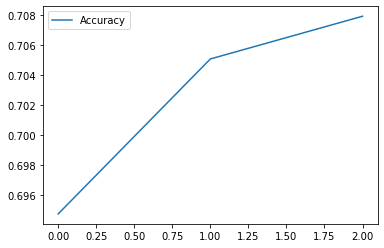

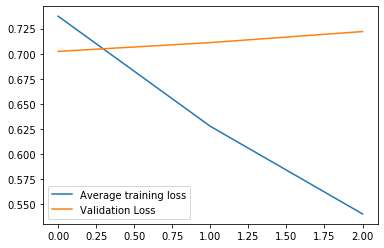

In [39]:
df_stats[['Accuracy']].plot(); df_stats[['Average training loss',  'Validation Loss']].plot()

In [32]:
input_ids, input_mask, labels = grab_batch_data(next(iter(valid_dl)))

In [33]:
loss, logits = model(input_ids, 
                             token_type_ids=None, 
                             attention_mask=input_mask, 
                             labels=labels)